### Бейзлайн модели

**Импорт библиотек**

In [1]:
import pandas as pd

In [2]:
from catboost import CatBoostClassifier

In [3]:
import re

In [4]:
from collections import Counter

In [5]:
import squarify

In [6]:
import nltk

In [7]:
from nltk.corpus import stopwords

In [8]:
from nltk.tokenize import word_tokenize

In [9]:
from nltk.stem import WordNetLemmatizer

In [10]:
import spacy

In [65]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [12]:
import matplotlib.pyplot as plt

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
import seaborn as sns

In [14]:
from sklearn.preprocessing import LabelBinarizer

In [15]:
import numpy as np

In [16]:
import optuna
from optuna.samplers import TPESampler

In [17]:
def plot_metrics(y_train_true, y_train_pred, y_val_true, y_val_pred):
    # Матрицы ошибок
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    conf_matrix_train = confusion_matrix(y_train_true, y_train_pred)
    sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues')
    plt.title('Матрица ошибок (train)')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.subplot(1, 2, 2)
    conf_matrix_val = confusion_matrix(y_val_true, y_val_pred)
    sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues')
    plt.title('Матрица ошибок (valid)')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

    # Отчёты о классификации
    report_train = classification_report(y_train_true, y_train_pred, output_dict=True)
    report_val = classification_report(y_val_true, y_val_pred, output_dict=True)

    df_report_train = pd.DataFrame(report_train).transpose()
    df_report_val = pd.DataFrame(report_val).transpose()

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(df_report_train.iloc[:-1, :].T, annot=True, fmt='.2f', cmap='GnBu')
    plt.title('Отчёт о классификации (train)')

    plt.subplot(1, 2, 2)
    sns.heatmap(df_report_val.iloc[:-1, :].T, annot=True, fmt='.2f', cmap='GnBu')
    plt.title('Отчёт о классификации (valid)')

    plt.tight_layout()
    plt.show()

In [18]:
def plot_curves(y_true, y_pred_proba, dataset, n_classes=3):
    fpr, tpr, roc_auc = dict(), dict(), dict()
    
    # ROC-кривая
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tpr = np.zeros_like(fpr_grid)
    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation
    mean_tpr /= n_classes

    fpr = fpr_grid
    tpr = mean_tpr
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='purple', label=f'AUC (ROC) = {roc_auc:.4f}')
    plt.fill_between(fpr, tpr, alpha=0.2, color='purple')
    plt.plot([0, 1], [0, 1], linestyle='--', color='dodgerblue', label='Кривая для случайного классификатора (y=х)')
    plt.title(f'ROC-кривая ({dataset})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()

**BoW + `catboost`**

_Чтение данных_

In [218]:
df = pd.read_parquet('df.parquet')

_preprocessing_

In [219]:
def delete_stopwords(tokens):
    cleaned = []
    for word in tokens:
        if word not in stop_words:
            cleaned.append(word)
    return cleaned

In [220]:
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/vladkopchev/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vladkopchev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [221]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vladkopchev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [222]:
df['cleaned_value'] = df.value.str.replace(r'[^a-zA-Z\s]', '', regex=True)

In [223]:
df['tokens'] = df.cleaned_value.apply(word_tokenize)

In [224]:
df['cleaned_tokens'] = df['tokens'].apply(delete_stopwords)

In [225]:
def lemmatize_tokens(tokens):
    lemmatized = []
    for word in tokens:
        lemmatized.append(lemmatizer.lemmatize(word))
    return lemmatized

df['lemmatized'] = df['cleaned_tokens'].apply(lemmatize_tokens)

_train test split + vectorizing_

In [226]:
# Делаем cutoff по промптам, тк тексты идут подряд
train_cutoff = round(df.shape[0] * .6)
val_cutoff = round(df.shape[0] * .8)

train_df = df.iloc[:train_cutoff, [2, 1]]
val_df = df.iloc[train_cutoff:val_cutoff, [2, 1]]
test_df = df.iloc[val_cutoff:, [2, 1]]

In [137]:
# new
prompts_list = df.prompt.unique()
train_cutoff = round(prompts_list.size * .6)
val_cutoff = round(prompts_list.size * .8)

train_df = df.loc[df.prompt.isin(prompts_list[:train_cutoff]), :].iloc[:, [2, 1]]
val_df = df.loc[df.prompt.isin(prompts_list[train_cutoff:val_cutoff]), :].iloc[:, [2, 1]]
test_df = df.loc[df.prompt.isin(prompts_list[val_cutoff:]), :].iloc[:, [2, 1]]

In [28]:
X_train = train_df.iloc[:, 0]
y_train = train_df.iloc[:, 1].replace({'human_output': 0, 'model_output': 1, 'human_edits': 2})

X_val = val_df.iloc[:, 0]
y_val = val_df.iloc[:, 1].replace({'human_output': 0, 'model_output': 1, 'human_edits': 2})

X_test = test_df.iloc[:, 0]
y_test = test_df.iloc[:, 1].replace({'human_output': 0, 'model_output': 1, 'human_edits': 2})

/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_45578/356371258.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = train_df.iloc[:, 1].replace({'human_output': 0, 'model_output': 1, 'human_edits': 2})
/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_45578/356371258.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val = val_df.iloc[:, 1].replace({'human_output': 0, 'model_output': 1, 'human_edits': 2})
/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_45578/356371258.py:8: FutureWarning

In [29]:
vectorizer = CountVectorizer()
X_train_lemmatized = vectorizer.fit_transform(X_train)
X_val_lemmatized = vectorizer.transform(X_val)
X_test_lemmatized = vectorizer.transform(X_test)

_baseline_

In [30]:
%%time

model_catboost_bow = CatBoostClassifier(random_state=42)
model_catboost_bow.fit(X_train_lemmatized, y_train, verbose=False)

CPU times: user 4min 24s, sys: 6.31 s, total: 4min 30s
Wall time: 1min 7s


In [31]:
y_train_pred = model_catboost_bow.predict(X_train_lemmatized)
y_val_pred = model_catboost_bow.predict(X_val_lemmatized)

In [32]:
y_train_pred_proba = model_catboost_bow.predict_proba(X_train_lemmatized)
y_val_pred_proba = model_catboost_bow.predict_proba(X_val_lemmatized)

_metrics_

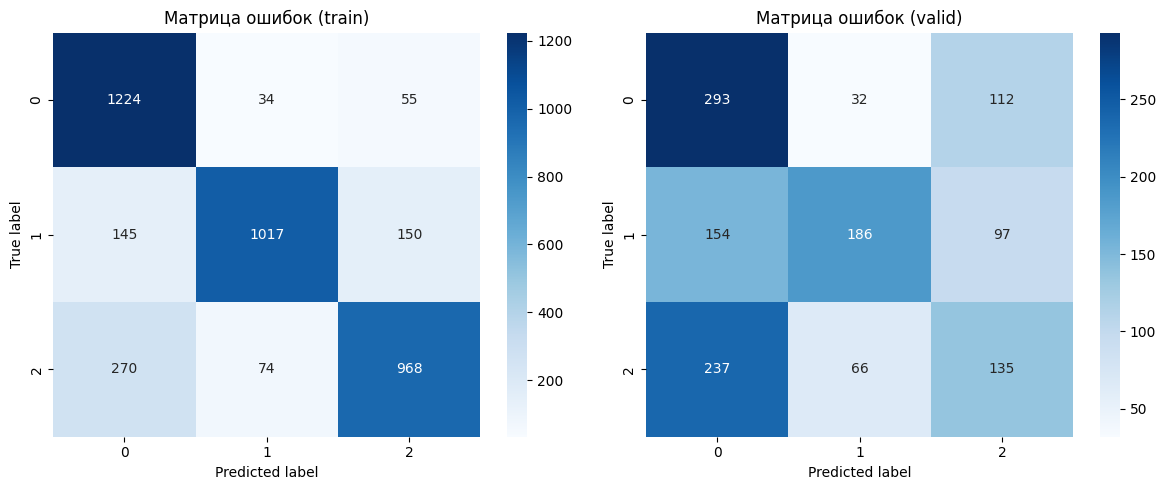

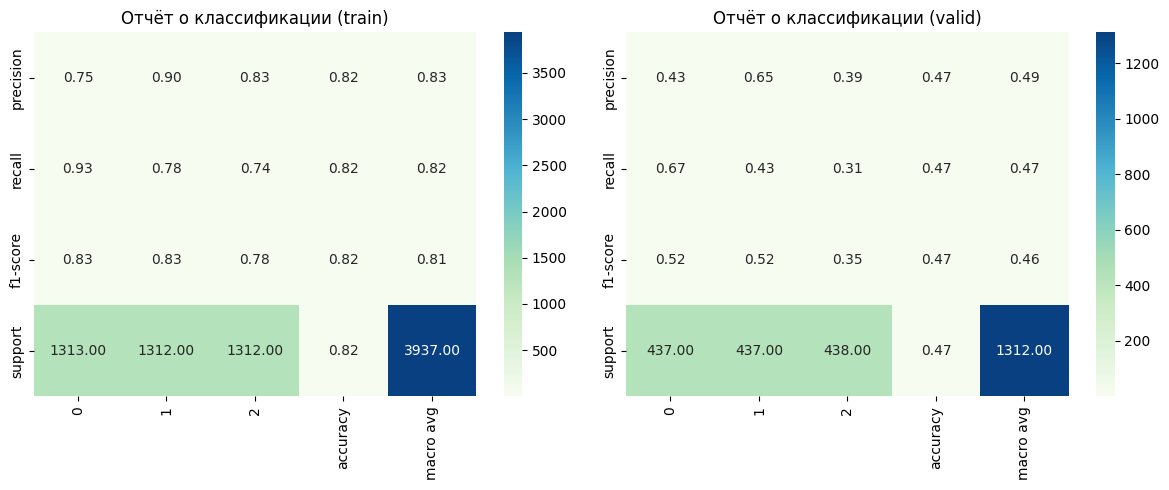

In [33]:
plot_metrics(y_train, y_train_pred, y_val, y_val_pred)

In [34]:
lb = LabelBinarizer().fit(y_train)

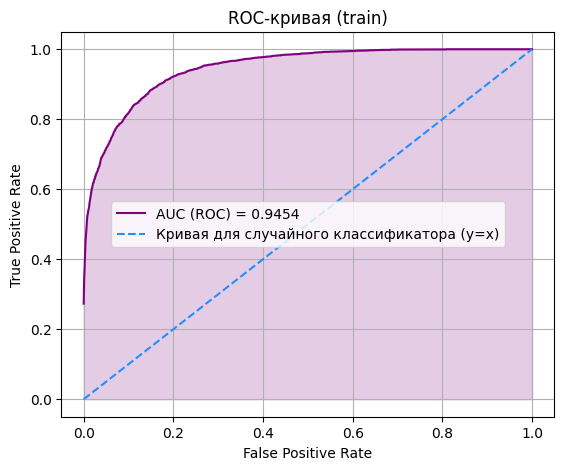

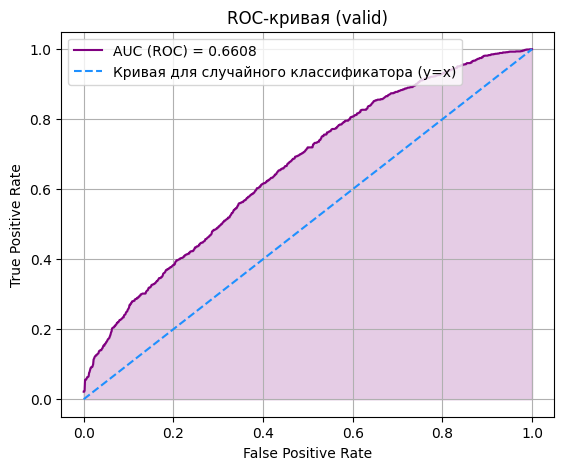

In [35]:
plot_curves(lb.transform(y_train), y_train_pred_proba, 'train')
plot_curves(lb.transform(y_val), y_val_pred_proba, 'valid')

Видим переобучение

_Подбор гиперпараметров_

In [36]:
sampler = TPESampler(seed=15)

In [37]:
def objective(trial, X_train_combined, y_train, X_val_combined, y_val):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 8)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1)
    # border_count = trial.suggest_int('border_count', 30, 130)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 2, 40)
    # l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 3, 10)


    model_catboost_bow = CatBoostClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            learning_rate=learning_rate,
                                            #border_count=border_count,
                                            min_data_in_leaf=min_data_in_leaf,
                                            #l2_leaf_reg=l2_leaf_reg,
                                            random_state=42
    )


    model_catboost_bow.fit(X_train_combined, y_train, verbose=False)

    y_train_pred_proba = model_catboost_bow.predict_proba(X_train_combined)
    y_val_pred_proba = model_catboost_bow.predict_proba(X_val_combined)

    roc_auc_train = roc_auc_score(y_train, y_train_pred_proba,
        multi_class="ovr",
        average="micro"
    )
    roc_auc_val = roc_auc_score(y_val, y_val_pred_proba,
        multi_class="ovr",
        average="micro"
    )

    return [roc_auc_val, abs(roc_auc_train - roc_auc_val)]

In [38]:
study = optuna.create_study(sampler=sampler, directions=['maximize', 'minimize'])
study.optimize(lambda trial: objective(trial, X_train_lemmatized, y_train, X_val_lemmatized, y_val), n_trials=50)

[I 2026-01-25 21:56:57,232] A new study created in memory with name: no-name-757f8fbd-02e6-43c2-87f6-7c52438b955e
[I 2026-01-25 21:57:12,920] Trial 0 finished with values: [0.6633877365593397, 0.12684500519646635] and parameters: {'n_estimators': 864, 'max_depth': 2, 'learning_rate': 0.055308851092125, 'min_data_in_leaf': 16}.
[I 2026-01-25 21:57:30,291] Trial 1 finished with values: [0.6702143789968769, 0.25068981765022613] and parameters: {'n_estimators': 348, 'max_depth': 5, 'learning_rate': 0.3066129968201801, 'min_data_in_leaf': 13}.
[I 2026-01-25 21:57:34,447] Trial 2 finished with values: [0.6438265680770374, 0.18805786988538686] and parameters: {'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.9177122679387258, 'min_data_in_leaf': 12}.
[I 2026-01-25 21:58:57,783] Trial 3 finished with values: [0.649595316218025, 0.3498838762887472] and parameters: {'n_estimators': 746, 'max_depth': 7, 'learning_rate': 0.8072724027631304, 'min_data_in_leaf': 10}.
[I 2026-01-25 21:59:01,07

Видим минимальное переобучение (`0.05`) и оптимум в `0.63`.

In [40]:
cb_res = study.trials_dataframe()

In [42]:
cb_res.to_csv('cb_res.csv')  # TODO: поменять на _res2 для tf-IDF

**`BoW` + `LogReg`**

In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
lr = LogisticRegression()

In [45]:
%%time

lr.fit(X_train_lemmatized, y_train)

CPU times: user 2.01 s, sys: 847 ms, total: 2.86 s
Wall time: 1.48 s


/opt/homebrew/Caskroom/miniconda/base/envs/hw-venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [46]:
y_train_pred = lr.predict(X_train_lemmatized)
y_val_pred = lr.predict(X_val_lemmatized)

In [47]:
y_train_pred_proba = lr.predict_proba(X_train_lemmatized)
y_val_pred_proba = lr.predict_proba(X_val_lemmatized)

_metrics_

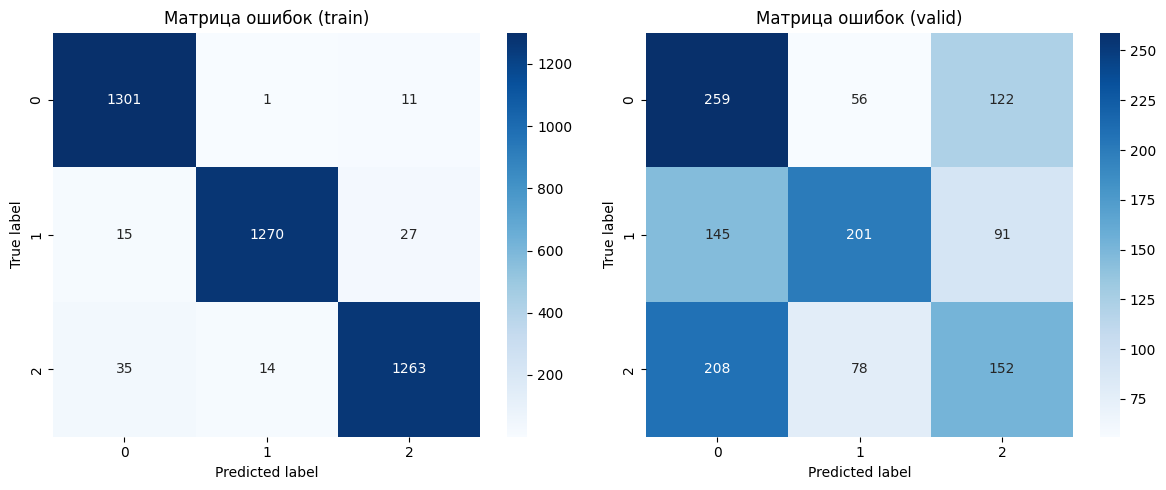

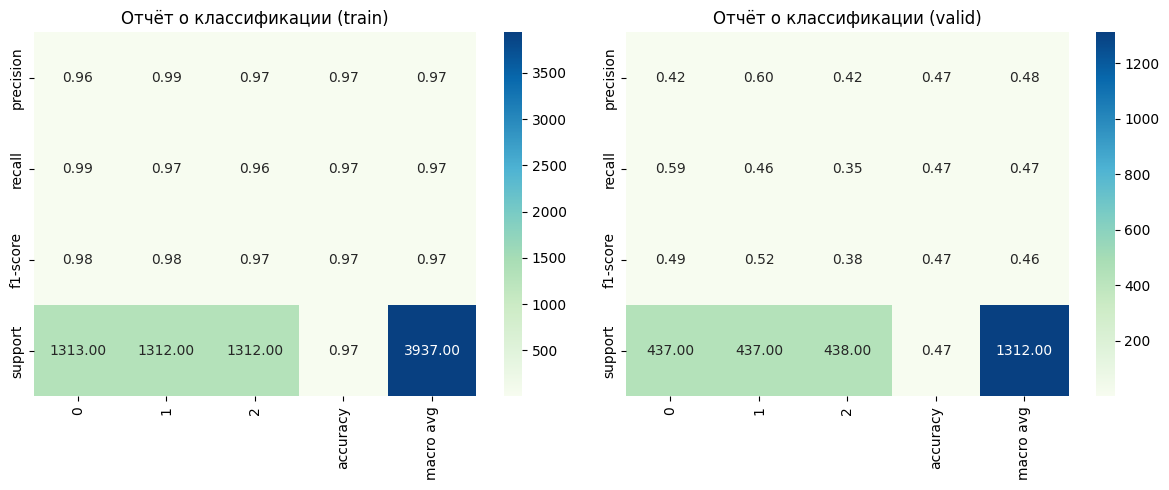

In [48]:
plot_metrics(y_train, y_train_pred, y_val, y_val_pred)

In [49]:
lb = LabelBinarizer().fit(y_train)

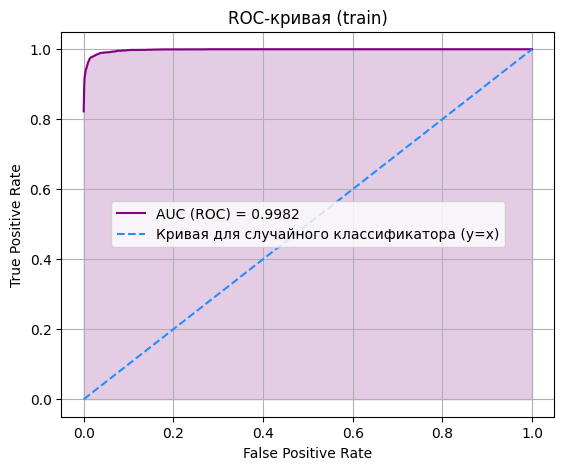

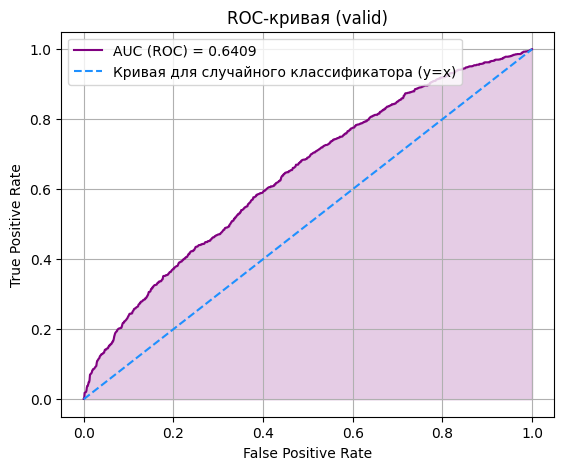

In [50]:
plot_curves(lb.transform(y_train), y_train_pred_proba, 'train')
plot_curves(lb.transform(y_val), y_val_pred_proba, 'valid')

То же самое, еще и переобучение видим.

_Подбор гиперпараметров_

In [51]:
sampler = TPESampler(seed=15)

In [59]:
def objective(trial, X_train_combined, y_train, X_val_combined, y_val):
    C = trial.suggest_float('C', 1e-6, 1e6, log=True)
    penalty = trial.suggest_categorical('penalty', ['l2'])
    solver = trial.suggest_categorical('solver', ['liblinear'])
    max_iter = trial.suggest_int('max_iter', 50, 2000)

    model_log_bow = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        max_iter=max_iter,
        random_state=42
    )


    model_log_bow.fit(X_train_combined, y_train)

    y_train_pred_proba = model_log_bow.predict_proba(X_train_combined)
    y_val_pred_proba = model_log_bow.predict_proba(X_val_combined)

    roc_auc_train = roc_auc_score(y_train, y_train_pred_proba,
        multi_class="ovr",
        average="micro"
    )
    roc_auc_val = roc_auc_score(y_val, y_val_pred_proba,
        multi_class="ovr",
        average="micro"
    )

    return [roc_auc_val, abs(roc_auc_train - roc_auc_val)]

In [60]:
study = optuna.create_study(sampler=sampler, directions=['maximize', 'minimize'])
study.optimize(lambda trial: objective(trial, X_train_lemmatized, y_train, X_val_lemmatized, y_val), n_trials=50)

[I 2026-01-25 22:11:18,941] A new study created in memory with name: no-name-5bfcd399-c850-41d6-b976-345848daf09b
[I 2026-01-25 22:11:19,397] Trial 0 finished with values: [0.6709260322166866, 0.11833867534498665] and parameters: {'C': 0.002017488850369506, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 1084}.
[I 2026-01-25 22:11:19,889] Trial 1 finished with values: [0.6812203138942594, 0.16378718257234648] and parameters: {'C': 0.004688425170268233, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 644}.
[I 2026-01-25 22:11:20,070] Trial 2 finished with values: [0.5543441636302796, 0.0024091434247216492] and parameters: {'C': 2.1922764274201788e-05, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 537}.
[I 2026-01-25 22:11:36,000] Trial 3 finished with values: [0.5994284117526769, 0.4005606849997101] and parameters: {'C': 102697.24047251463, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 565}.
[I 2026-01-25 22:11:52,795] Trial 4 finished with values: [0.601847742229327

In [61]:
bow_res = study.trials_dataframe()# .iloc[3]

In [63]:
bow_res.to_csv('lr_res.csv')  # TODO: поменять на _res2 для tf-IDF

**`tf-IF` + `catboost`**

In [66]:
vectorizer = TfidfVectorizer()
X_train_lemmatized = vectorizer.fit_transform(X_train)
X_val_lemmatized = vectorizer.transform(X_val)
X_test_lemmatized = vectorizer.transform(X_test)

_baseline_

In [67]:
%%time

model_catboost_bow = CatBoostClassifier(random_state=42)
model_catboost_bow.fit(X_train_lemmatized, y_train, verbose=False)

CPU times: user 18min 51s, sys: 23.8 s, total: 19min 15s
Wall time: 3min 46s


In [68]:
y_train_pred = model_catboost_bow.predict(X_train_lemmatized)
y_val_pred = model_catboost_bow.predict(X_val_lemmatized)

In [69]:
y_train_pred_proba = model_catboost_bow.predict_proba(X_train_lemmatized)
y_val_pred_proba = model_catboost_bow.predict_proba(X_val_lemmatized)

_metrics_

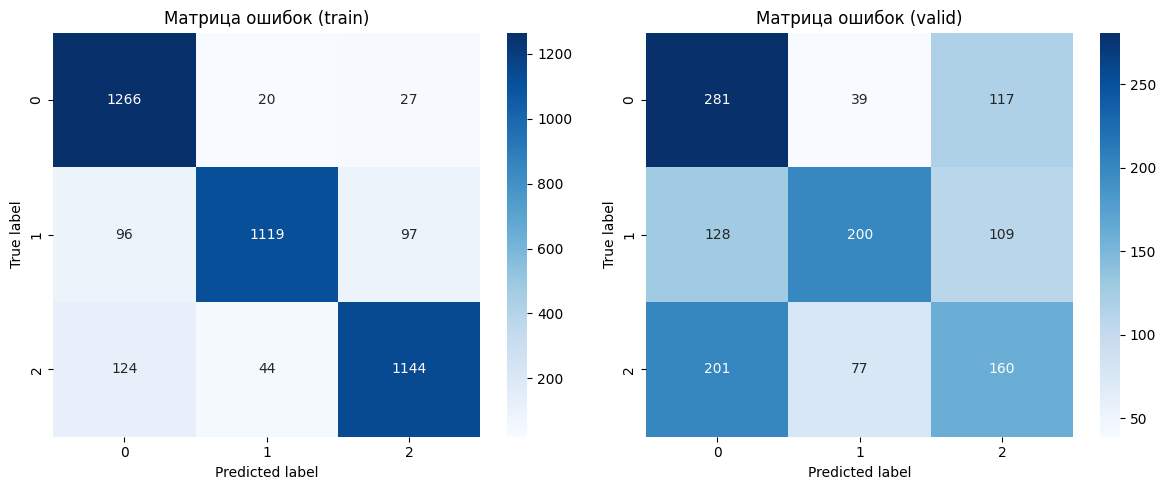

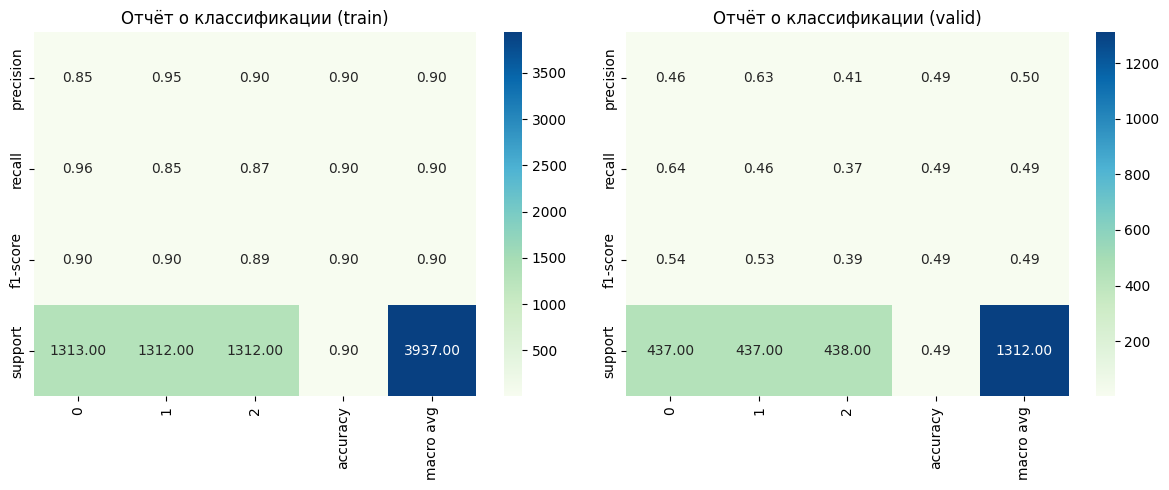

In [70]:
plot_metrics(y_train, y_train_pred, y_val, y_val_pred)

In [71]:
lb = LabelBinarizer().fit(y_train)

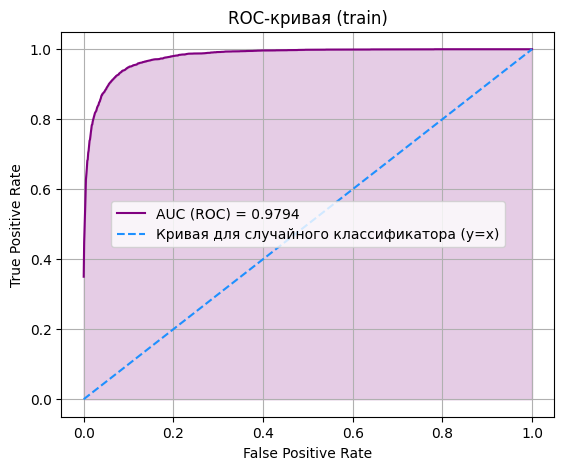

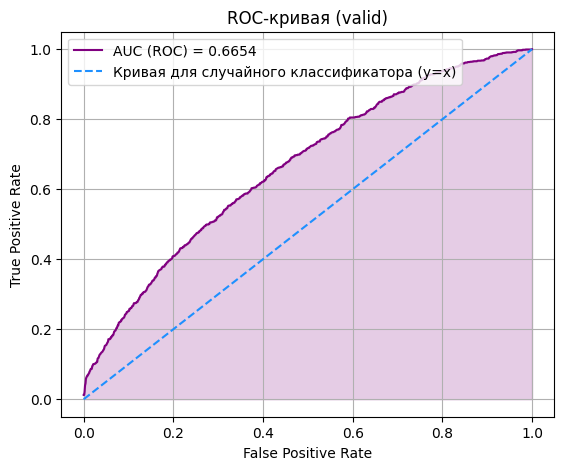

In [72]:
plot_curves(lb.transform(y_train), y_train_pred_proba, 'train')
plot_curves(lb.transform(y_val), y_val_pred_proba, 'valid')

Видим переобучение

_Подбор гиперпараметров_

In [73]:
sampler = TPESampler(seed=15)

In [74]:
def objective(trial, X_train_combined, y_train, X_val_combined, y_val):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 8)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1)
    # border_count = trial.suggest_int('border_count', 30, 130)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 2, 40)
    # l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 3, 10)


    model_catboost_bow = CatBoostClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            learning_rate=learning_rate,
                                            #border_count=border_count,
                                            min_data_in_leaf=min_data_in_leaf,
                                            #l2_leaf_reg=l2_leaf_reg,
                                            random_state=42
    )


    model_catboost_bow.fit(X_train_combined, y_train, verbose=False)

    y_train_pred_proba = model_catboost_bow.predict_proba(X_train_combined)
    y_val_pred_proba = model_catboost_bow.predict_proba(X_val_combined)

    roc_auc_train = roc_auc_score(y_train, y_train_pred_proba,
        multi_class="ovr",
        average="micro"
    )
    roc_auc_val = roc_auc_score(y_val, y_val_pred_proba,
        multi_class="ovr",
        average="micro"
    )

    return [roc_auc_val, abs(roc_auc_train - roc_auc_val)]

In [75]:
study = optuna.create_study(sampler=sampler, directions=['maximize', 'minimize'])
study.optimize(lambda trial: objective(trial, X_train_lemmatized, y_train, X_val_lemmatized, y_val), n_trials=50)

[I 2026-01-25 22:21:00,705] A new study created in memory with name: no-name-19b92d35-2c45-49a6-9cf0-09c849866e43
[I 2026-01-25 22:21:26,150] Trial 0 finished with values: [0.6695091161325104, 0.14645658031501152] and parameters: {'n_estimators': 864, 'max_depth': 2, 'learning_rate': 0.055308851092125, 'min_data_in_leaf': 16}.
[I 2026-01-25 22:22:06,118] Trial 1 finished with values: [0.6696996649129981, 0.29344419685859635] and parameters: {'n_estimators': 348, 'max_depth': 5, 'learning_rate': 0.3066129968201801, 'min_data_in_leaf': 13}.
[I 2026-01-25 22:22:12,307] Trial 2 finished with values: [0.6391958841463414, 0.22421822977866057] and parameters: {'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.9177122679387258, 'min_data_in_leaf': 12}.
[I 2026-01-25 22:26:36,019] Trial 3 finished with values: [0.6393190437239739, 0.36056740766183215] and parameters: {'n_estimators': 746, 'max_depth': 7, 'learning_rate': 0.8072724027631304, 'min_data_in_leaf': 10}.
[I 2026-01-25 22:26:39,

Видим минимальное переобучение (`0.05`) и оптимум в `0.63`.

In [76]:
cb_res = study.trials_dataframe()

In [77]:
cb_res.to_csv('cb_res2.csv')  # TODO: поменять на _res2 для tf-IDF

**`tf-Idf` + `LogReg`**

In [78]:
from sklearn.linear_model import LogisticRegression

In [79]:
lr = LogisticRegression()

In [80]:
%%time

lr.fit(X_train_lemmatized, y_train)

CPU times: user 763 ms, sys: 1.48 s, total: 2.24 s
Wall time: 480 ms


LogisticRegression()

In [81]:
y_train_pred = lr.predict(X_train_lemmatized)
y_val_pred = lr.predict(X_val_lemmatized)

In [82]:
y_train_pred_proba = lr.predict_proba(X_train_lemmatized)
y_val_pred_proba = lr.predict_proba(X_val_lemmatized)

_metrics_

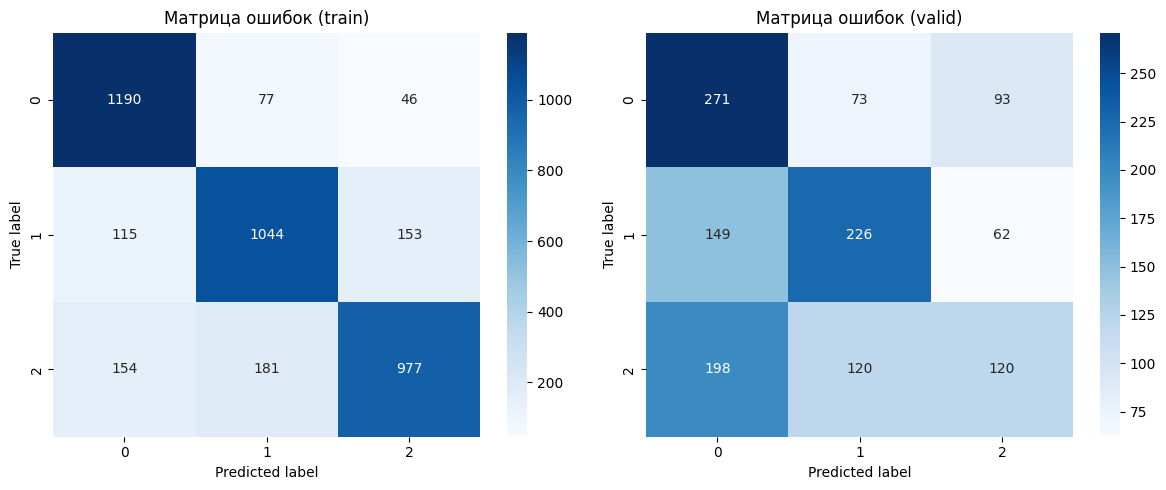

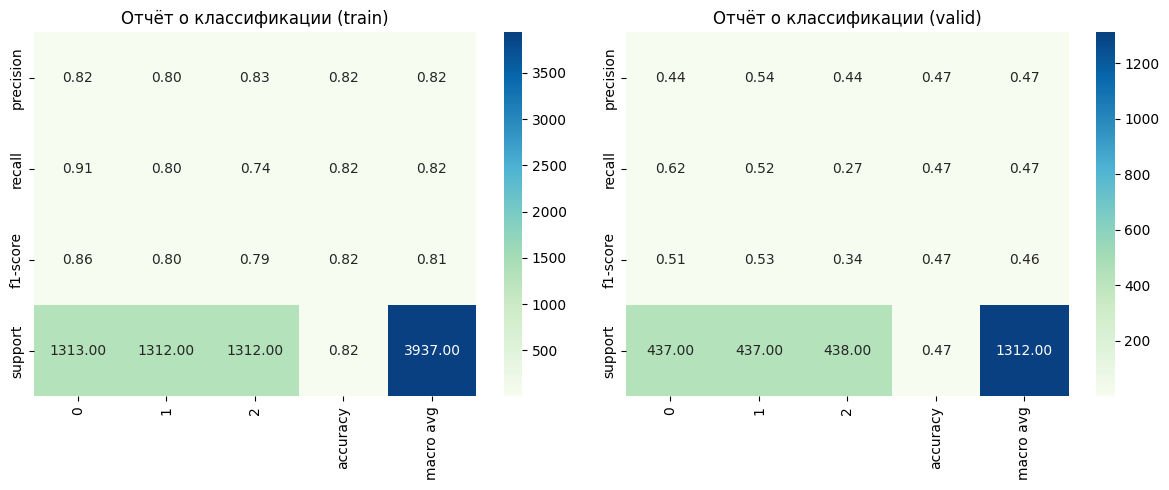

In [83]:
plot_metrics(y_train, y_train_pred, y_val, y_val_pred)

In [84]:
lb = LabelBinarizer().fit(y_train)

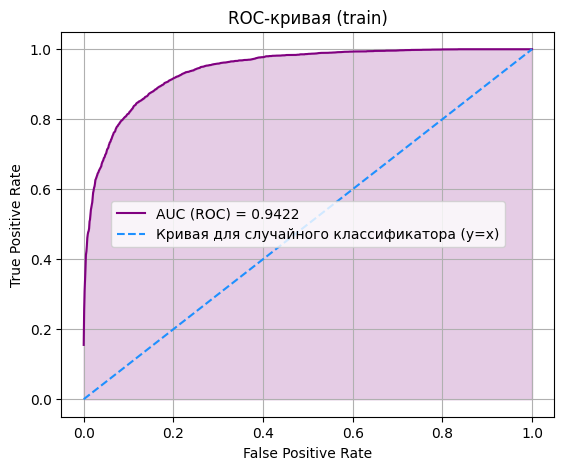

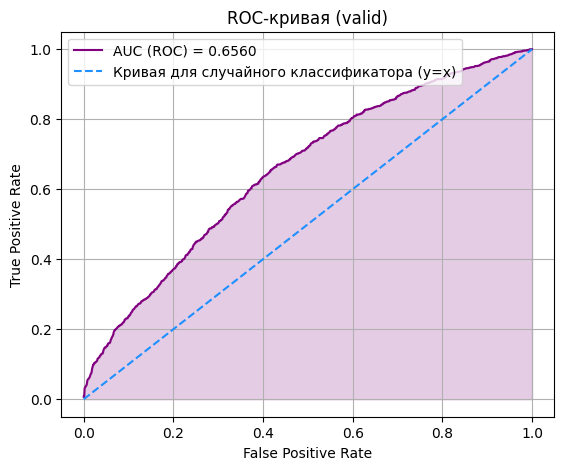

In [85]:
plot_curves(lb.transform(y_train), y_train_pred_proba, 'train')
plot_curves(lb.transform(y_val), y_val_pred_proba, 'valid')

То же самое, еще и переобучение видим.

_Подбор гиперпараметров_

In [86]:
sampler = TPESampler(seed=15)

In [87]:
def objective(trial, X_train_combined, y_train, X_val_combined, y_val):
    C = trial.suggest_float('C', 1e-6, 1e6, log=True)
    penalty = trial.suggest_categorical('penalty', ['l2'])
    solver = trial.suggest_categorical('solver', ['liblinear'])
    max_iter = trial.suggest_int('max_iter', 50, 2000)

    model_log_bow = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        max_iter=max_iter,
        random_state=42
    )


    model_log_bow.fit(X_train_combined, y_train)

    y_train_pred_proba = model_log_bow.predict_proba(X_train_combined)
    y_val_pred_proba = model_log_bow.predict_proba(X_val_combined)

    roc_auc_train = roc_auc_score(y_train, y_train_pred_proba,
        multi_class="ovr",
        average="micro"
    )
    roc_auc_val = roc_auc_score(y_val, y_val_pred_proba,
        multi_class="ovr",
        average="micro"
    )

    return [roc_auc_val, abs(roc_auc_train - roc_auc_val)]

In [88]:
study = optuna.create_study(sampler=sampler, directions=['maximize', 'minimize'])
study.optimize(lambda trial: objective(trial, X_train_lemmatized, y_train, X_val_lemmatized, y_val), n_trials=50)

[I 2026-01-25 22:49:15,086] A new study created in memory with name: no-name-25b4dee8-709c-4175-a033-3227c01afe03
[I 2026-01-25 22:49:17,469] Trial 0 finished with values: [0.6011741406714753, 0.39881495608091166] and parameters: {'C': 15339.541094142276, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 399}.
[I 2026-01-25 22:49:17,536] Trial 1 finished with values: [0.5547545987321535, 0.05697814086235786] and parameters: {'C': 4.49116045877472e-06, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 755}.
[I 2026-01-25 22:49:17,635] Trial 2 finished with values: [0.6070738910990482, 0.09568957894402097] and parameters: {'C': 0.002017488850369506, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 1084}.
[I 2026-01-25 22:49:17,804] Trial 3 finished with values: [0.6261520068039858, 0.09923415364575461] and parameters: {'C': 0.004688425170268233, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 644}.
[I 2026-01-25 22:49:17,894] Trial 4 finished with values: [0.5551874000780785, 

In [89]:
bow_res = study.trials_dataframe()# .iloc[3]

In [90]:
bow_res.to_csv('lr_res2.csv')  # TODO: поменять на _res2 для tf-IDF

**`BERT` + `catboost`**

В `dataset.ipynb` получаем эмбеддинги, тут смотрим на `catboost`.

In [101]:
df = pd.read_csv('emb.csv').drop(columns='Unnamed: 0')

In [105]:
# Делаем cutoff по промптам, тк тексты идут подряд
train_cutoff = round(df.shape[0] * .6)
val_cutoff = round(df.shape[0] * .8)

train_df = df.iloc[:train_cutoff]
val_df = df.iloc[train_cutoff:val_cutoff]
test_df = df.iloc[val_cutoff:]

In [109]:
X_train_lemmatized = train_df.iloc[:, 3:].values
y_train = train_df.iloc[:, 1].replace({'human_output': 0, 'model_output': 1, 'human_edits': 2})

X_val_lemmatized = val_df.iloc[:, 3:].values
y_val = val_df.iloc[:, 1].replace({'human_output': 0, 'model_output': 1, 'human_edits': 2})

X_test_lemmatized = test_df.iloc[:, 3:].values
y_test = test_df.iloc[:, 1].replace({'human_output': 0, 'model_output': 1, 'human_edits': 2})

/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_45578/4138733271.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = train_df.iloc[:, 1].replace({'human_output': 0, 'model_output': 1, 'human_edits': 2})
/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_45578/4138733271.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val = val_df.iloc[:, 1].replace({'human_output': 0, 'model_output': 1, 'human_edits': 2})
/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_45578/4138733271.py:8: FutureWarn

_baseline_

In [110]:
%%time

model_catboost_bow = CatBoostClassifier(random_state=42)
model_catboost_bow.fit(X_train_lemmatized, y_train, verbose=False)

CPU times: user 6min 40s, sys: 9.2 s, total: 6min 49s
Wall time: 1min 11s


In [111]:
y_train_pred = model_catboost_bow.predict(X_train_lemmatized)
y_val_pred = model_catboost_bow.predict(X_val_lemmatized)

In [112]:
y_train_pred_proba = model_catboost_bow.predict_proba(X_train_lemmatized)
y_val_pred_proba = model_catboost_bow.predict_proba(X_val_lemmatized)

_metrics_

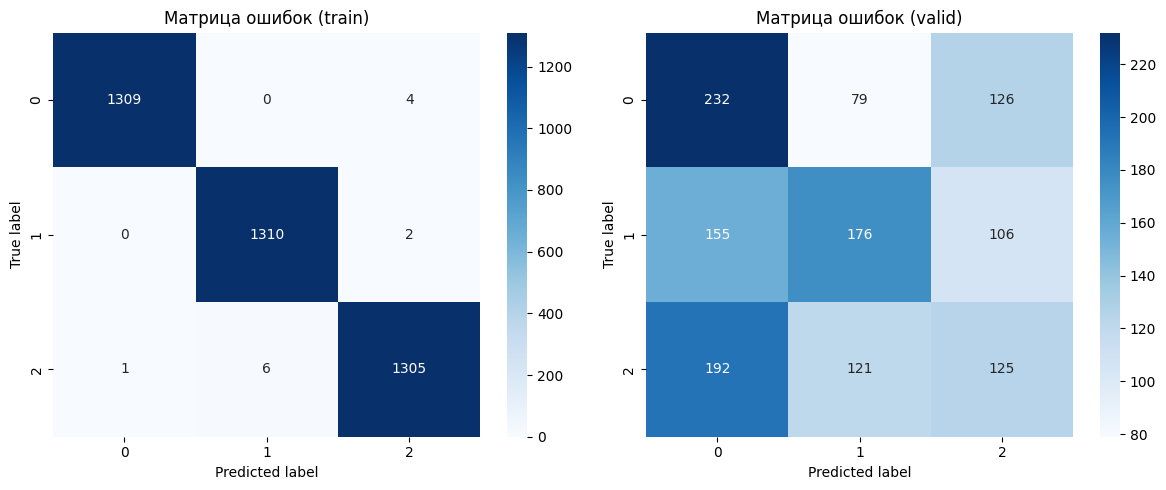

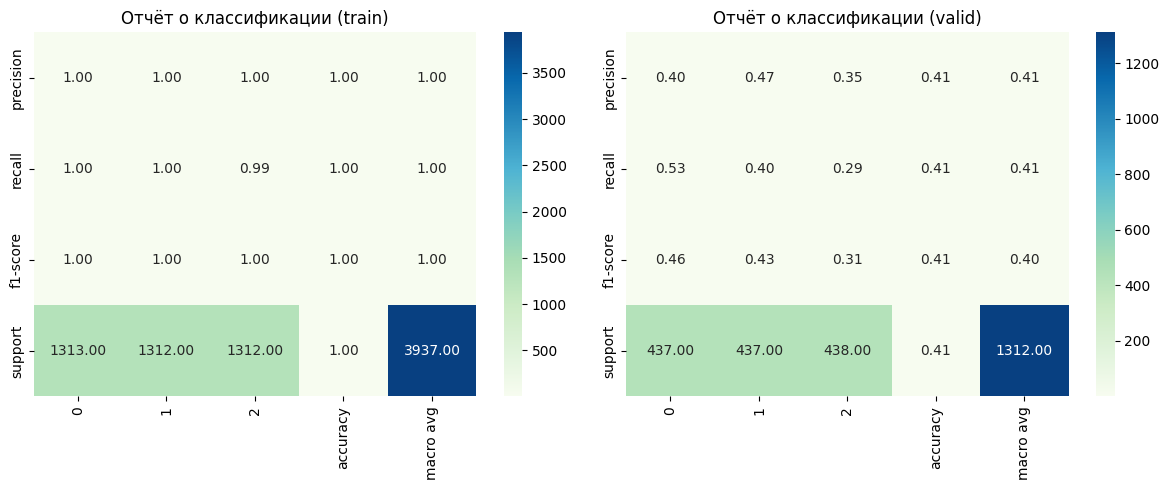

In [113]:
plot_metrics(y_train, y_train_pred, y_val, y_val_pred)

In [114]:
lb = LabelBinarizer().fit(y_train)

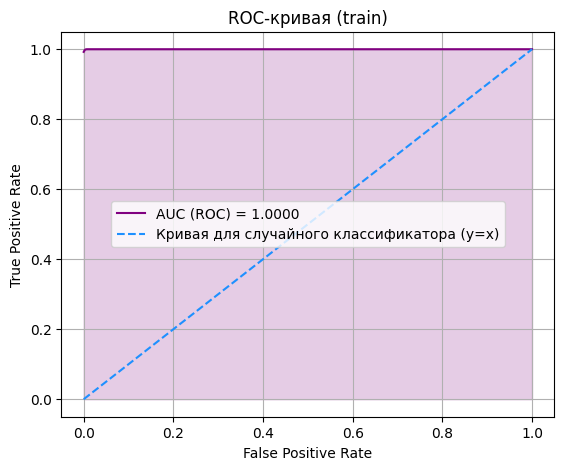

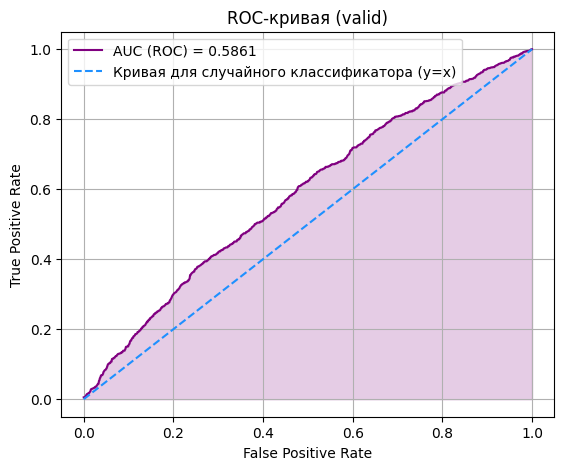

In [115]:
plot_curves(lb.transform(y_train), y_train_pred_proba, 'train')
plot_curves(lb.transform(y_val), y_val_pred_proba, 'valid')

Видим переобучение

_Подбор гиперпараметров_

In [116]:
sampler = TPESampler(seed=15)

In [117]:
def objective(trial, X_train_combined, y_train, X_val_combined, y_val):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 8)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1)
    # border_count = trial.suggest_int('border_count', 30, 130)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 2, 40)
    # l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 3, 10)


    model_catboost_bow = CatBoostClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            learning_rate=learning_rate,
                                            #border_count=border_count,
                                            min_data_in_leaf=min_data_in_leaf,
                                            #l2_leaf_reg=l2_leaf_reg,
                                            random_state=42
    )


    model_catboost_bow.fit(X_train_combined, y_train, verbose=False)

    y_train_pred_proba = model_catboost_bow.predict_proba(X_train_combined)
    y_val_pred_proba = model_catboost_bow.predict_proba(X_val_combined)

    roc_auc_train = roc_auc_score(y_train, y_train_pred_proba,
        multi_class="ovr",
        average="micro"
    )
    roc_auc_val = roc_auc_score(y_val, y_val_pred_proba,
        multi_class="ovr",
        average="micro"
    )

    return [roc_auc_val, abs(roc_auc_train - roc_auc_val)]

In [118]:
study = optuna.create_study(sampler=sampler, directions=['maximize', 'minimize'])
study.optimize(lambda trial: objective(trial, X_train_lemmatized, y_train, X_val_lemmatized, y_val), n_trials=50)

[I 2026-01-25 23:14:24,417] A new study created in memory with name: no-name-50605ee0-9286-4a22-9820-8e9906f12593
[I 2026-01-25 23:14:31,191] Trial 0 finished with values: [0.5834847653926234, 0.23057576595424567] and parameters: {'n_estimators': 864, 'max_depth': 2, 'learning_rate': 0.055308851092125, 'min_data_in_leaf': 16}.
[I 2026-01-25 23:14:45,108] Trial 1 finished with values: [0.5717709533945567, 0.4280512397982168] and parameters: {'n_estimators': 348, 'max_depth': 5, 'learning_rate': 0.3066129968201801, 'min_data_in_leaf': 13}.
[I 2026-01-25 23:14:46,657] Trial 2 finished with values: [0.5665590375892327, 0.28062920517434964] and parameters: {'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.9177122679387258, 'min_data_in_leaf': 12}.
[I 2026-01-25 23:16:22,282] Trial 3 finished with values: [0.5605985787849495, 0.43939051796743767] and parameters: {'n_estimators': 746, 'max_depth': 7, 'learning_rate': 0.8072724027631304, 'min_data_in_leaf': 10}.
[I 2026-01-25 23:16:23,3

Видим минимальное переобучение (`0.05`) и оптимум в `0.63`.

In [119]:
cb_res = study.trials_dataframe()

In [120]:
cb_res.to_csv('cb_res3.csv')

**lr**

In [121]:
from sklearn.linear_model import LogisticRegression

In [122]:
lr = LogisticRegression()

In [123]:
%%time

lr.fit(X_train_lemmatized, y_train)

CPU times: user 1.41 s, sys: 63.1 ms, total: 1.47 s
Wall time: 240 ms


LogisticRegression()

In [124]:
y_train_pred = lr.predict(X_train_lemmatized)
y_val_pred = lr.predict(X_val_lemmatized)

In [125]:
y_train_pred_proba = lr.predict_proba(X_train_lemmatized)
y_val_pred_proba = lr.predict_proba(X_val_lemmatized)

_metrics_

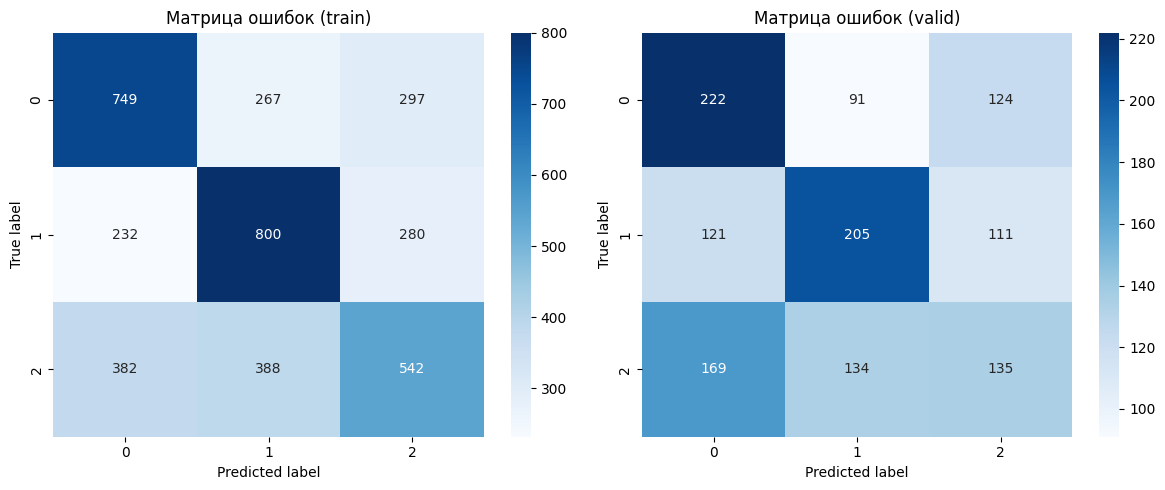

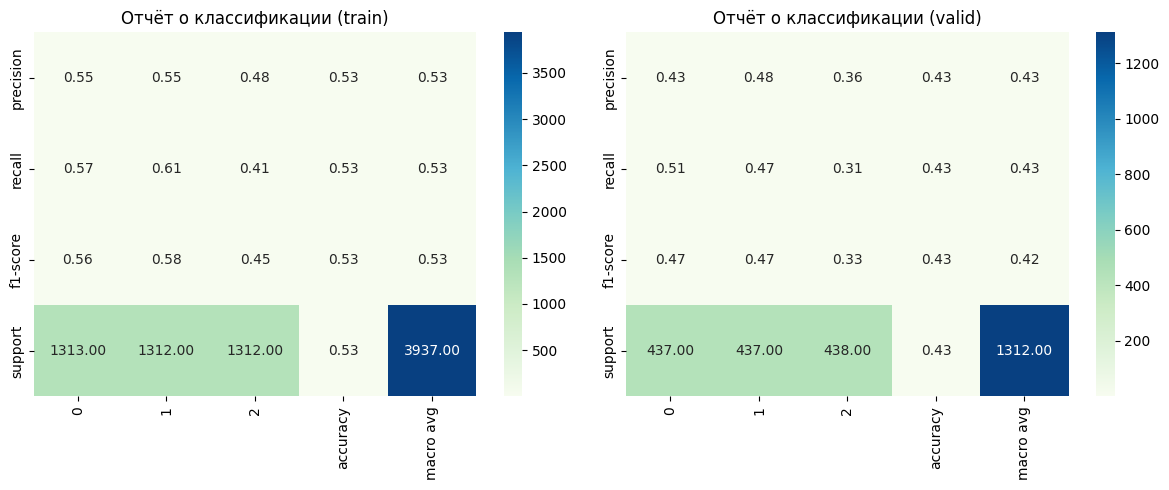

In [126]:
plot_metrics(y_train, y_train_pred, y_val, y_val_pred)

In [127]:
lb = LabelBinarizer().fit(y_train)

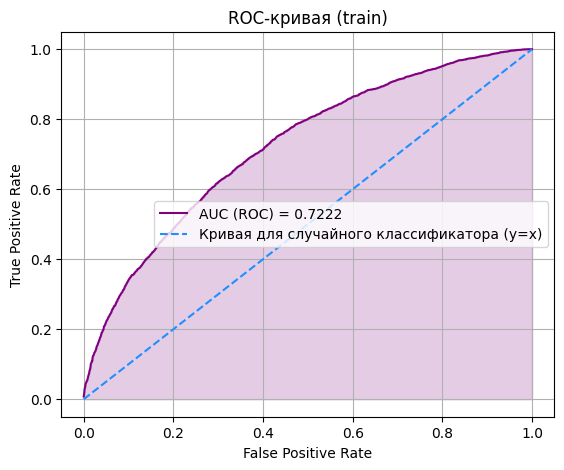

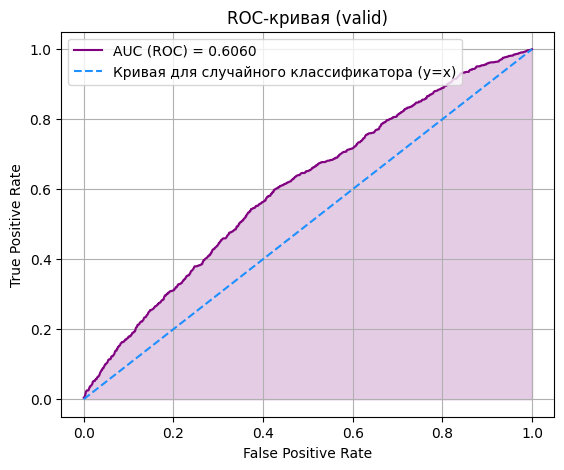

In [128]:
plot_curves(lb.transform(y_train), y_train_pred_proba, 'train')
plot_curves(lb.transform(y_val), y_val_pred_proba, 'valid')

То же самое, еще и переобучение видим.

_Подбор гиперпараметров_

In [129]:
sampler = TPESampler(seed=15)

In [130]:
def objective(trial, X_train_combined, y_train, X_val_combined, y_val):
    C = trial.suggest_float('C', 1e-6, 1e6, log=True)
    penalty = trial.suggest_categorical('penalty', ['l2'])
    solver = trial.suggest_categorical('solver', ['liblinear'])
    max_iter = trial.suggest_int('max_iter', 50, 2000)

    model_log_bow = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        max_iter=max_iter,
        random_state=42
    )


    model_log_bow.fit(X_train_combined, y_train)

    y_train_pred_proba = model_log_bow.predict_proba(X_train_combined)
    y_val_pred_proba = model_log_bow.predict_proba(X_val_combined)

    roc_auc_train = roc_auc_score(y_train, y_train_pred_proba,
        multi_class="ovr",
        average="micro"
    )
    roc_auc_val = roc_auc_score(y_val, y_val_pred_proba,
        multi_class="ovr",
        average="micro"
    )

    return [roc_auc_val, abs(roc_auc_train - roc_auc_val)]

In [131]:
study = optuna.create_study(sampler=sampler, directions=['maximize', 'minimize'])
study.optimize(lambda trial: objective(trial, X_train_lemmatized, y_train, X_val_lemmatized, y_val), n_trials=50)

[I 2026-01-25 23:37:24,320] A new study created in memory with name: no-name-a81326ad-6a60-43f5-bc9b-6072225e280d
[I 2026-01-25 23:37:26,865] Trial 0 finished with values: [0.605784201182332, 0.11972750790560216] and parameters: {'C': 15339.541094142276, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 399}.
[I 2026-01-25 23:37:26,988] Trial 1 finished with values: [0.5642410813875669, 0.021137670015097143] and parameters: {'C': 4.49116045877472e-06, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 755}.
[I 2026-01-25 23:37:27,276] Trial 2 finished with values: [0.5859168765801607, 0.04727697045269463] and parameters: {'C': 0.002017488850369506, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 1084}.
[I 2026-01-25 23:37:27,598] Trial 3 finished with values: [0.5901220209324807, 0.05455907488132383] and parameters: {'C': 0.004688425170268233, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 644}.
[I 2026-01-25 23:37:27,766] Trial 4 finished with values: [0.5652632477877751, 

In [132]:
bow_res = study.trials_dataframe()# .iloc[3]

In [133]:
bow_res.to_csv('lr_res3.csv')

**Интерпретация**

_Вывод._ `optuna` для катбуста выдает почему-то одни пни. Для `lr` сложные эмбеддинги улучшают рехультат, для `catboost` наоборот.

Топ для `catboost + BOW`:

In [184]:
df = pd.read_csv('cb_res.csv').iloc[:, 1:]

In [198]:
df.query('values_1 < 0.05').sort_values('values_0').iloc[-3:, [1, 6, 7, 8, 9]].rename(columns={'values_0': 'roc_auc'})

,roc_auc,params_learning_rate,params_max_depth,params_min_data_in_leaf,params_n_estimators
11,0.608694,0.018703,1,4,109
13,0.615904,0.007065,2,7,294
22,0.632467,0.095869,1,4,100


Топ для `catboost + tf-IDF`

In [201]:
df = pd.read_csv('cb_res2.csv').iloc[:, 1:]

In [203]:
df.query('values_1 < 0.05').sort_values('values_0').iloc[-3:, [1, 6, 7, 8, 9]].rename(columns={'values_0': 'roc_auc'})

,roc_auc,params_learning_rate,params_max_depth,params_min_data_in_leaf,params_n_estimators
11,0.602312,0.018703,1,4,109
13,0.609274,0.007065,2,7,294
4,0.635563,0.040383,1,9,250


Топ для `catboost + BERT`

In [155]:
df = pd.read_csv('cb_res3.csv').iloc[:, 1:]

In [167]:
df.query('values_1 < 0.08').sort_values('values_0').iloc[-3:, [1, 6, 7, 8, 9]].rename(columns={'values_0': 'roc_auc'})

,roc_auc,params_learning_rate,params_max_depth,params_min_data_in_leaf,params_n_estimators
31,0.574083,0.074863,1,23,180
47,0.575027,0.085001,1,26,190
23,0.578264,0.090366,1,23,195


Топ для `lr + BOW`

In [182]:
df = pd.read_csv('lr_res.csv').iloc[:, 1:]

In [183]:
df.query('values_1 < 0.05').sort_values('values_0').iloc[-3:, [1, 6, 7, 8, 9]].rename(columns={'values_0': 'roc_auc'})

,roc_auc,params_C,params_max_iter,params_penalty,params_solver
43,0.588966,0.000120,1409,l2,liblinear
14,0.594275,0.000145,1346,l2,liblinear
31,0.599642,0.000175,1389,l2,liblinear


Топ для `lr + tf-IDF`

In [179]:
df = pd.read_csv('lr_res2.csv').iloc[:, 1:]

In [181]:
df.query('values_1 < 0.08').sort_values('values_0').iloc[-3:, [1, 6, 7, 8, 9]].rename(columns={'values_0': 'roc_auc'})

,roc_auc,params_C,params_max_iter,params_penalty,params_solver
48,0.560604,0.000199,833,l2,liblinear
20,0.561294,0.000217,241,l2,liblinear
30,0.570037,0.000471,401,l2,liblinear


Топ для `lr + BERT`

In [174]:
df = pd.read_csv('lr_res3.csv').iloc[:, 1:]

In [177]:
df.query('values_1 < 0.08').sort_values('values_0').iloc[-3:, [1, 6, 7, 8,]].rename(columns={'values_0': 'roc_auc'})

,roc_auc,params_C,params_max_iter,params_penalty,params_solver
15,0.599509,0.022562,880,l2,liblinear
20,0.605252,0.053938,898,l2,liblinear
41,0.605333,0.054684,1875,l2,liblinear


**Анализ ошибочных кейсов**

Возьмем наилучшую модель и посмотрим, где она вообще ошибается.

In [204]:
vectorizer = TfidfVectorizer()
X_train_lemmatized = vectorizer.fit_transform(X_train)
X_val_lemmatized = vectorizer.transform(X_val)
X_test_lemmatized = vectorizer.transform(X_test)

_baseline_

In [205]:
%%time

model_catboost_bow = CatBoostClassifier(random_state=42, max_depth=1, min_data_in_leaf=9, n_estimators=250)
model_catboost_bow.fit(X_train_lemmatized, y_train, verbose=False)

CPU times: user 19.5 s, sys: 1.15 s, total: 20.7 s
Wall time: 4.48 s


In [207]:
y_train_pred = model_catboost_bow.predict(X_train_lemmatized)
y_val_pred = model_catboost_bow.predict(X_val_lemmatized)

In [208]:
y_train_pred_proba = model_catboost_bow.predict_proba(X_train_lemmatized)
y_val_pred_proba = model_catboost_bow.predict_proba(X_val_lemmatized)

_metrics_

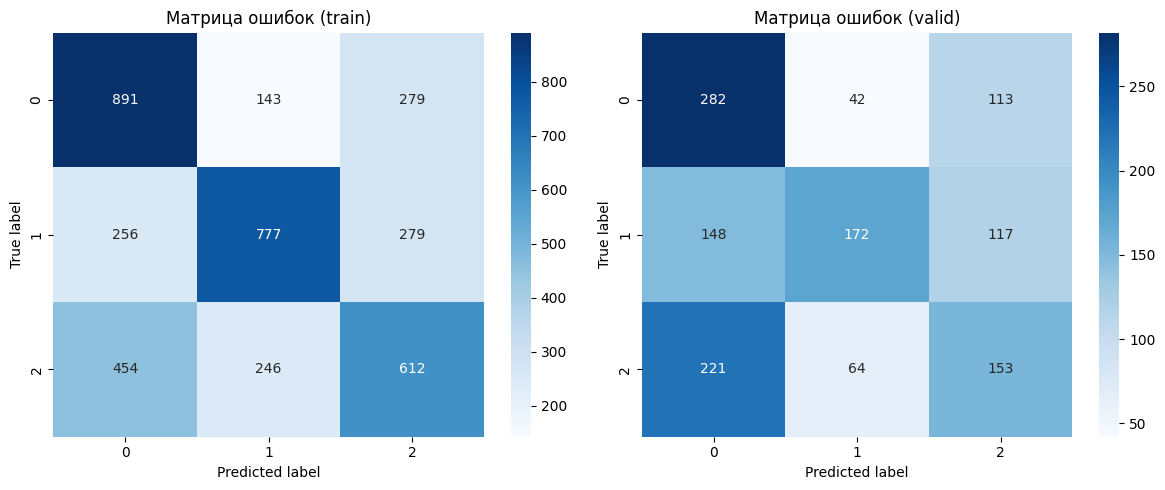

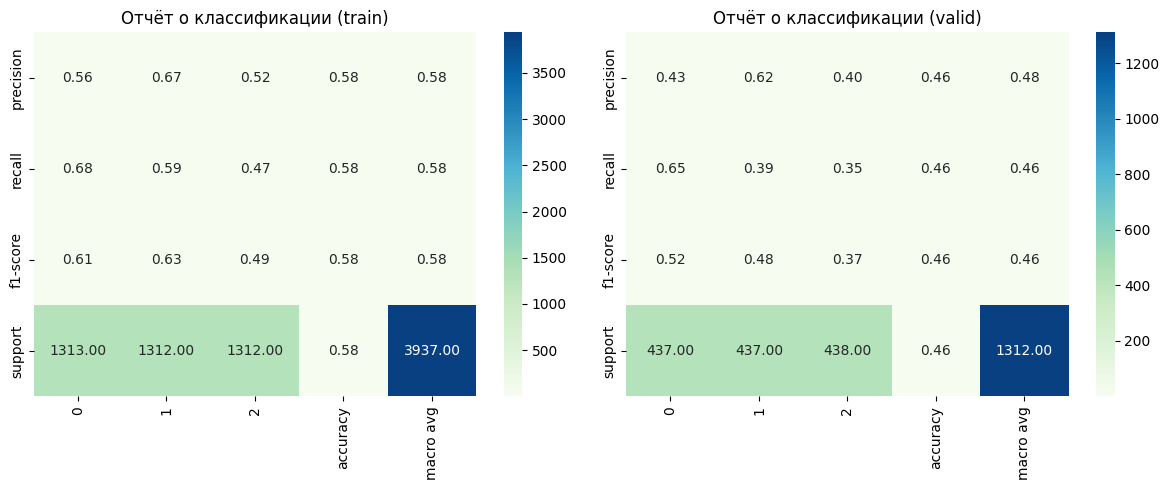

In [209]:
plot_metrics(y_train, y_train_pred, y_val, y_val_pred)

In [210]:
lb = LabelBinarizer().fit(y_train)

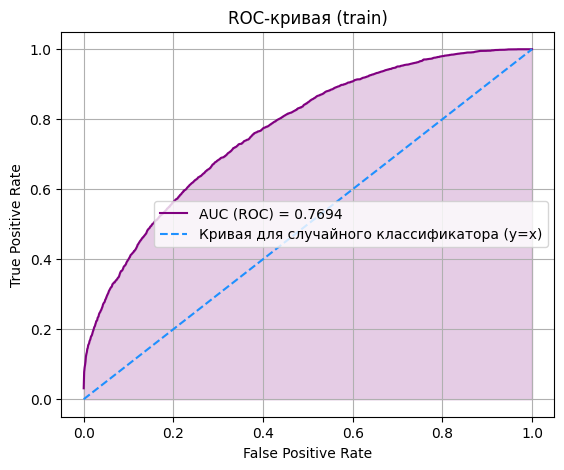

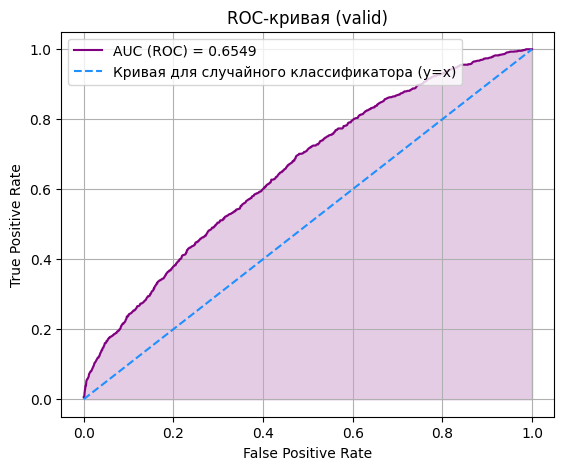

In [211]:
plot_curves(lb.transform(y_train), y_train_pred_proba, 'train')
plot_curves(lb.transform(y_val), y_val_pred_proba, 'valid')

Переобучение все равно довольно сильное, но уже меньше, чем было. Пока для примера поработаем с этой моделью.

In [232]:
vectorizer = TfidfVectorizer()
X_train_lemmatized = vectorizer.fit_transform(X_train)
X_val_lemmatized = vectorizer.transform(X_val)
X_test_lemmatized = vectorizer.transform(X_test)

_baseline_

In [243]:
df = df.assign(y_pred = model_catboost_bow.predict(vectorizer.transform(df.iloc[:, 2])))
df.y_pred.replace(
    {0: 'human_output', 1: 'model_output', 2: 'human_edits'},
    inplace=True
)

/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_45578/4002464938.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.y_pred.replace(


Не распознал половину случаев...

In [246]:
df.loc[df.y_pred != df.variable].to_parquet('df2.parquet')

**TODO: Дообученный BERT**

Запускать в колабе:

_Импорт библиотек_

Локально совсем не запускается, пробую колаб. Тогда `pip install` не трогать, которые закомменчены.

In [ ]:
# !pip install tensorflow_text

In [ ]:
# !pip install tf-keras==2.16.0 --no-dependencies

In [13]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [4]:
%%time

import pandas as pd

from transformers import AutoTokenizer

from datasets import Dataset, load_dataset
from huggingface_hub import login

from transformers import DataCollatorWithPadding

import evaluate
import numpy as np

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

CPU times: user 5 s, sys: 450 ms, total: 5.45 s
Wall time: 6.89 s


_Загружаем предобработанные данные_

In [48]:
df = pd.read_parquet('df.parquet')

In [49]:
dataset = df.rename(columns={'value': 'text', 'variable': 'label'}).drop(columns='prompt')

In [50]:
dataset.label = dataset.label.replace({'human_output': 0, 'model_output': 1, 'human_edits': 2})

/tmp/ipython-input-2489221204.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset.label = dataset.label.replace({'human_output': 0, 'model_output': 1, 'human_edits': 2})


In [53]:
dataset = Dataset.from_pandas(dataset)

_Дообучаем `DeBERTa`_

In [9]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [56]:
def preprocess_function(example):
    text = example['text']
    labels = example['label']
    example = tokenizer(text, truncation=True, max_length=512)
    example['labels'] = labels

    return example

tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=['text'])

Map:   0%|          | 0/6561 [00:00<?, ? examples/s]

In [57]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [58]:
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = sigmoid(predictions)
    predictions = (predictions > 0.5).astype(int).reshape(-1)

    return clf_metrics.compute(predictions=predictions, references=labels.astype(int).reshape(-1))

In [59]:
model = AutoModelForSequenceClassification.from_pretrained(

   'microsoft/deberta-v3-small', num_labels=3,
                       problem_type = "single_label_classification"
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TODO. Что за ворнинг вылезает? Все запускается и по идее работает адекватно?

In [60]:
training_args = TrainingArguments(

   output_dir="my_awesome_model",
   learning_rate=2e-5,
   per_device_train_batch_size=3,
   per_device_eval_batch_size=3,
   num_train_epochs=2,
   weight_decay=0.01,
   eval_strategy="epoch",
   save_strategy="epoch",
   load_best_model_at_end=True,
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_dataset,
   eval_dataset=tokenized_dataset,  # TODO: как правильно подобрать eval датасет?
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipython-input-729631744.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 